In [1]:
import os

dataset_path = "/content/drive/MyDrive/predictathon"
folders = [
    "train/fake_cifake_images",
    "train/real_cifake_images",
    "test/test_images",
    "outputs",
    "notebooks"
]

for folder in folders:
    path = os.path.join(dataset_path, folder)
    if os.path.exists(path):
        print(f"✅ {folder} exists.")
    else:
        print(f"❌ {folder} is missing!")


✅ train/fake_cifake_images exists.
✅ train/real_cifake_images exists.
✅ test/test_images exists.
✅ outputs exists.
✅ notebooks exists.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
fake_count = len(os.listdir(f"{dataset_path}/train/fake_cifake_images"))
real_count = len(os.listdir(f"{dataset_path}/train/real_cifake_images"))
test_count = len(os.listdir(f"{dataset_path}/test/test_images"))

print(f"Fake Images: {fake_count}")
print(f"Real Images: {real_count}")
print(f"Test Images: {test_count}")


Fake Images: 1000
Real Images: 1000
Test Images: 500


In [5]:
import json

dataset_path = "/content/drive/MyDrive/predictathon"  # Ensure the correct path

# to load json files
with open(f"{dataset_path}/fake_cifake_preds.json", "r") as f:
    fake_preds = json.load(f)

with open(f"{dataset_path}/real_cifake_preds.json", "r") as f:
    real_preds = json.load(f)

# print a few samples to check
if isinstance(fake_preds, dict):
    print("🔹 Fake Predictions Sample:", list(fake_preds.items())[:3])
elif isinstance(fake_preds, list):
    print("🔹 Fake Predictions Sample (List):", fake_preds[:3])

if isinstance(real_preds, dict):
    print("🔹 Real Predictions Sample:", list(real_preds.items())[:3])
elif isinstance(real_preds, list):
    print("🔹 Real Predictions Sample (List):", real_preds[:3])


🔹 Fake Predictions Sample (List): [{'index': 1, 'prediction': 'fake'}, {'index': 2, 'prediction': 'fake'}, {'index': 3, 'prediction': 'fake'}]
🔹 Real Predictions Sample (List): [{'index': 1, 'prediction': 'real'}, {'index': 2, 'prediction': 'fake'}, {'index': 3, 'prediction': 'real'}]


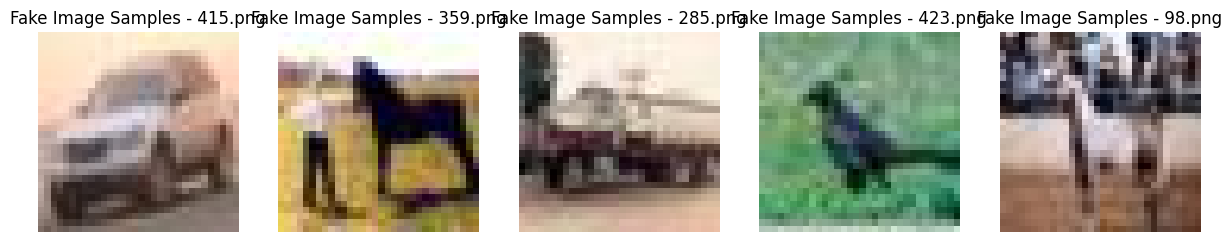

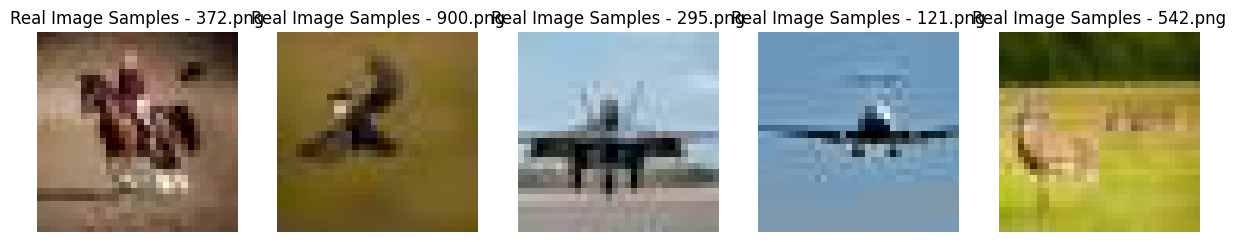

In [7]:
import cv2
import matplotlib.pyplot as plt
import random

# diplay image function
def show_images(folder, title, num_images=5):
    image_files = os.listdir(folder)
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title} - {img_file}")
        plt.axis("off")

    plt.show()

# Display images
show_images(f"{dataset_path}/train/fake_cifake_images", "Fake Image Samples")
show_images(f"{dataset_path}/train/real_cifake_images", "Real Image Samples")


In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFakeDataset(Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.label = label  # 0 for real, 1 for fake
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
fake_dataset = CIFakeDataset(f"{dataset_path}/train/fake_cifake_images", label=1, transform=transform)
real_dataset = CIFakeDataset(f"{dataset_path}/train/real_cifake_images", label=0, transform=transform)

# Combine datasets
full_dataset = fake_dataset + real_dataset

# Create DataLoader
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)


In [9]:
import pickle

with open(f"{dataset_path}/outputs/dataset.pkl", "wb") as f:
    pickle.dump(full_dataset, f)

print("✅ Dataset saved for future use!")


✅ Dataset saved for future use!


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet-18 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Single output neuron (Binary classification)

# Move model to GPU if available
model = model.to(device)

print("✅ Model loaded and modified for classification.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


✅ Model loaded and modified for classification.


In [11]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("✅ Loss function and optimizer set.")


✅ Loss function and optimizer set.


In [12]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(images).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

print("✅ Training function is ready.")


✅ Training function is ready.


In [13]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


100%|██████████| 63/63 [06:13<00:00,  5.93s/it]


Epoch [1/10], Loss: 0.3096, Accuracy: 86.70%


100%|██████████| 63/63 [00:14<00:00,  4.44it/s]


Epoch [2/10], Loss: 0.0896, Accuracy: 97.00%


100%|██████████| 63/63 [00:14<00:00,  4.44it/s]


Epoch [3/10], Loss: 0.0303, Accuracy: 99.05%


100%|██████████| 63/63 [00:14<00:00,  4.49it/s]


Epoch [4/10], Loss: 0.0269, Accuracy: 99.30%


100%|██████████| 63/63 [00:14<00:00,  4.42it/s]


Epoch [5/10], Loss: 0.0251, Accuracy: 99.25%


100%|██████████| 63/63 [00:13<00:00,  4.52it/s]


Epoch [6/10], Loss: 0.0157, Accuracy: 99.75%


100%|██████████| 63/63 [00:14<00:00,  4.49it/s]


Epoch [7/10], Loss: 0.0140, Accuracy: 99.60%


100%|██████████| 63/63 [00:14<00:00,  4.49it/s]


Epoch [8/10], Loss: 0.0221, Accuracy: 99.35%


100%|██████████| 63/63 [00:14<00:00,  4.33it/s]


Epoch [9/10], Loss: 0.0139, Accuracy: 99.60%


100%|██████████| 63/63 [00:13<00:00,  4.54it/s]

Epoch [10/10], Loss: 0.0084, Accuracy: 99.85%


In [14]:
model_path = f"{dataset_path}/outputs/cifake_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at: {model_path}")


✅ Model saved at: /content/drive/MyDrive/predictathon/outputs/cifake_model.pth


In [15]:
# Load model
model_path = "/content/drive/MyDrive/predictathon/outputs/cifake_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Set model to evaluation mode

print("✅ Model loaded for testing.")


✅ Model loaded for testing.


<ipython-input-15-d397532b574d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [16]:
# Importing necessary libraries
import torch
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet18(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)


model_path = "/content/drive/MyDrive/predictathon/outputs/cifake_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded successfully for testing!")


✅ Model loaded successfully for testing!


<ipython-input-16-770bc0763e6a>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create Test Dataset Class
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]  # Return filename for predictions

# Load Test Dataset
test_dataset = TestDataset("/content/drive/MyDrive/predictathon/test/test_images", transform=transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Test dataset prepared with {len(test_dataset)} images.")


✅ Test dataset prepared with 500 images.


In [18]:
import json
import torch.nn.functional as F
from tqdm import tqdm

# Dictionary to store predictions
predictions = {}

# Disable gradient calculations for inference
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images).squeeze()  # Get raw model outputs
        probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted_labels = (probabilities > 0.5).float()  # Threshold at 0.5

        # Store predictions
        for filename, label in zip(filenames, predicted_labels):
            predictions[filename] = "fake" if label.item() == 1 else "real"

# Save predictions as JSON
submission_path = "/content/drive/MyDrive/predictathon/outputs/teamname_prediction.json"
with open(submission_path, "w") as f:
    json.dump(predictions, f)

print(f"✅ Predictions saved at: {submission_path}")


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


✅ Predictions saved at: /content/drive/MyDrive/predictathon/outputs/teamname_prediction.json


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:  # Ensure labels exist
            images, labels = images.to(device), labels.to(device)  # Move tensors to GPU
            outputs = model(images).squeeze()  # Forward pass
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary

            all_preds.extend(preds.cpu().numpy())  # Convert tensors to NumPy arrays
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

# Use `train_loader` instead of `test_loader` (since test data has no labels)
evaluate_model(model, train_loader)



✅ Accuracy: 0.9980
✅ Precision: 0.9980
✅ Recall: 0.9980
✅ F1 Score: 0.9980


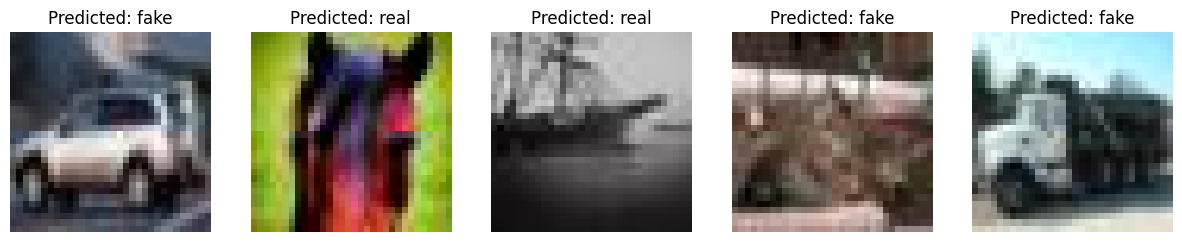

In [20]:
import matplotlib.pyplot as plt
import random

# Select random test images
test_images = os.listdir("/content/drive/MyDrive/predictathon/test/test_images")
random_images = random.sample(test_images, 5)

plt.figure(figsize=(15, 5))

for i, img_name in enumerate(random_images):
    img_path = f"/content/drive/MyDrive/predictathon/test/test_images/{img_name}"
    image = Image.open(img_path).convert("RGB")

    # Get prediction
    predicted_label = predictions[img_name]

    # Display image with predicted label
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")

plt.show()


In [21]:
import torch
import json
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()

# Dictionary to store predictions
predictions = {"fake": 0, "real": 0}

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images).squeeze()
        probabilities = torch.sigmoid(outputs)  # Convert to probability
        predicted_labels = (probabilities > 0.5).float()  # Threshold at 0.5

        for filename, label in zip(filenames, predicted_labels):
            category = "fake" if label.item() == 1 else "real"
            predictions[category] += 1

# Print the count of fake & real images
print(f"✅ Fake images in test set: {predictions['fake']}")
print(f"✅ Real images in test set: {predictions['real']}")


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]

✅ Fake images in test set: 248
✅ Real images in test set: 252


<ipython-input-23-7f90774e5d4c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


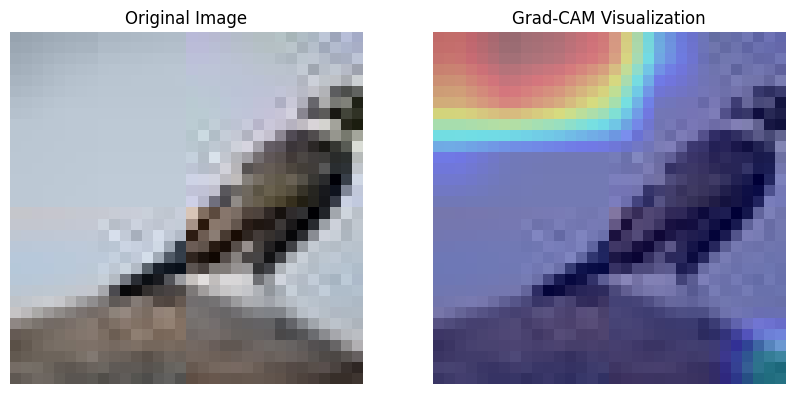

In [23]:
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
from PIL import Image

# ✅ Load the trained model (Fixing warnings)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Fix deprecated 'pretrained' warning
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)  # Modify for binary classification

# ✅ Fix `torch.load` security warning
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/predictathon/outputs/cifake_model.pth",
    map_location=device
), strict=False)  # Use strict=False to handle potential missing keys

model.to(device)
model.eval()  # Set model to evaluation mode

# ✅ Store activations and gradients globally
activations = None
gradients = None

# ✅ Hook function to capture activations and gradients
def save_activations(module, inp, out):
    global activations
    activations = out  # Store forward pass activations

def save_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]  # Store gradients from backward pass

# ✅ Grad-CAM function
def apply_gradcam(image_path, model):
    global activations, gradients  # Access global variables

    # ✅ Select the last convolutional layer in ResNet
    target_layer = model.layer4[1].conv2  # Last conv layer
    forward_hook = target_layer.register_forward_hook(save_activations)
    backward_hook = target_layer.register_full_backward_hook(save_gradients)

    # ✅ Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # ✅ Forward pass
    model.zero_grad()
    output = model(img_tensor).squeeze()
    output.backward()  # Compute gradients

    # ✅ Ensure activations and gradients exist
    if activations is None or gradients is None:
        print("⚠️ No activations or gradients found! Try a different layer.")
        return

    # ✅ Convert tensors to numpy
    activations_np = activations.cpu().detach().numpy()[0]  # Remove batch dim
    gradients_np = gradients.cpu().detach().numpy()[0]

    # ✅ Compute Grad-CAM heatmap
    weights = np.mean(gradients_np, axis=(1, 2))  # Global Average Pooling
    heatmap = np.sum(weights[:, None, None] * activations_np, axis=0)
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU to remove negative values

    # ✅ Fix divide by zero
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)  # Normalize
    else:
        heatmap = np.zeros_like(heatmap)  # Return blank heatmap if all zeros

    # ✅ Apply heatmap to image
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # ✅ Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Visualization")
    plt.axis("off")

    plt.show()

    # ✅ Remove hooks after execution to free memory
    forward_hook.remove()
    backward_hook.remove()

# ✅ Run Grad-CAM on a test image
apply_gradcam("/content/drive/MyDrive/DATASET/DATASET/test/10.png", model)


In [24]:
!pip install flask flask-cors torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [26]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from flask import Flask, request, jsonify
from flask_cors import CORS
from PIL import Image
import io

app = Flask(__name__)
CORS(app)  # Enable CORS for cross-origin requests

# ✅ Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)

model_path = "/content/drive/MyDrive/predictathon/outputs/cifake_model.pth"
try:
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.to(device)
    model.eval()
except Exception as e:
    print(f"🚨 Model loading failed: {e}")

# ✅ Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

@app.route("/predict", methods=["POST"])
def predict():
    try:
        if "file" not in request.files:
            return jsonify({"error": "No file part in request"}), 400

        file = request.files["file"]
        if file.filename == "":
            return jsonify({"error": "No selected file"}), 400

        image = Image.open(io.BytesIO(file.read()))
        img_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor).squeeze()
            probability = torch.sigmoid(output).item()

        result = {"label": "FAKE" if probability > 0.5 else "REAL", "confidence": probability}
        return jsonify(result)

    except Exception as e:
        return jsonify({"error": f"Internal Server Error: {str(e)}"}), 500

# ✅ Run Flask API
if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)



<ipython-input-26-77574cbdf04c>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device), strict=False)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [27]:
!pip install pyngrok


In [28]:
!ngrok config add-authtoken 2siFdv9spJC5ChvOYTVUEXewS6G_3Bd9K6b5Y47JbW3NQDgMW


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [29]:
from pyngrok import ngrok

# Expose Flask API on port 5000
public_url = ngrok.connect(5000)
print("🚀 API is running at:", public_url)


🚀 API is running at: NgrokTunnel: "https://d96c-35-233-209-63.ngrok-free.app" -> "http://localhost:5000"


In [31]:
!curl -X POST -F "/content/drive/MyDrive/DATASET/DATASET/test/10.png" https://d96c-35-233-209-63.ngrok-free.app/

curl: option -F: is badly used here
curl: try 'curl --help' or 'curl --manual' for more information
